In [1]:
import aiml
import pandas as pd

k = aiml.Kernel()
k.learn("./aiml/novagraphs_abc.xml")

#load questions from file
dataset = pd.read_csv("./validation_data.csv")

dataset[['Global Subject', 'Question Intent']] = dataset[['Global Subject', 'Question Intent']].apply(
    lambda col: col.str.strip().str.upper()
)

dataset

Loading ./aiml/novagraphs_abc.xml...done (0.00 seconds)


,Question,Global Subject,Question Intent
0,Hello!,START,START
1,Hi!,START,START
2,Hey!,START,START
3,Greetings!,START,START
4,Hello again!,START,START
...,...,...,...
463,What does the 14th Amendment also introduce th...,OFF_TOPIC,OFF_TOPIC
464,"Statistically, what is a Jehovah's Witnesses l...",OFF_TOPIC,OFF_TOPIC
465,What concept does not reach back to the Hebrew...,OFF_TOPIC,OFF_TOPIC
466,Were there any laws against marriage between w...,OFF_TOPIC,OFF_TOPIC


In [2]:
# # Let's add the OT questions from SQUAD v2
# splits = {'train': 'squad_v2/train-00000-of-00001.parquet',
#           'validation': 'squad_v2/validation-00000-of-00001.parquet'}
# df_squad_v2 = pd.read_parquet("hf://datasets/rajpurkar/squad_v2/" + splits["train"])
#
# # Double square parenthesis to get a dataframe
# sampled_ot_examples = df_squad_v2.sample(100, random_state=102460)[['question']]
# sampled_ot_examples.rename(columns={'question': 'Question'}, inplace=True)
#
# sampled_ot_examples['Global Subject'] = 'OFF_TOPIC'
# sampled_ot_examples['Question Intent'] = ''
#
# dataset = pd.concat([dataset, sampled_ot_examples], ignore_index=True)
#
# dataset

In [3]:
preds_aiml = pd.DataFrame(columns=["aiml_main_prediction", "aiml_sub_prediction"])

for idx, q in enumerate(dataset['Question']):
    pred: str = k.respond(q).upper().strip()

    split = pred.split(':')
    if len(split) == 2:
        preds_aiml.loc[idx] = [split[0], split[1]]
    else:
        preds_aiml.loc[idx] = [pred, "ND"]

preds_aiml

,aiml_main_prediction,aiml_sub_prediction
0,START,GREET
1,START,GREET
2,OFF_TOPIC,ND
3,OFF_TOPIC,ND
4,START,GREET
...,...,...
463,OFF_TOPIC,ND
464,OFF_TOPIC,ND
465,OFF_TOPIC,ND
466,OFF_TOPIC,ND


In [4]:
from pathlib import Path
from system.runner import load_model, BertModelComponents

models_dir = Path("../artifacts/test_config")

submodels_dict: dict[str, Path | None] = {}
for submodel in models_dir.glob("question_intent_*"):
    sub_name = submodel.name.replace("question_intent_", "")

    if (submodel / "trained_model").exists() and any((submodel / "trained_model").iterdir()):
        submodels_dict[sub_name] = submodel
    else:
        submodels_dict[sub_name] = None
        print(f"Skipping {submodel.name} because it does not have a trained model.")

# load each submodel using `load_model` and create a dictionary of submodels.
# If the path is none, set the submodel to none instead of loading it.
submodels: dict[str, BertModelComponents | None] = {}
for name, path in submodels_dict.items():
    submodels[name] = None if path is None else load_model(f"question_intent_{name}", path.parent)
    # if submodels[name] is not None:
    #     print(f"Submodel '{name}' is based on: {type(submodels[name].model).__name__}")

# Main Model loading
model = load_model("global_subject_classifier", Path("../artifacts/test_config"))
base_model = type(model.model).__name__

preds_bert = pd.DataFrame(columns=["bert_main_prediction", "bert_sub_prediction"])

for idx, q in enumerate(dataset['Question']):
    q: str

    main_class_prediction = model.classify(q)
    main_class = main_class_prediction.get_label()

    sub_class_prediction = submodels[main_class].classify(q) if submodels.get(main_class) else None
    sub_class = sub_class_prediction.get_label().upper() if sub_class_prediction else "ND"

    # if sub_class == "ND":
    #     print(main_class, sub_class)

    preds_bert.loc[idx] = [main_class.upper().strip(), sub_class.upper().strip()]

preds_bert

Skipping question_intent_off_topic because it does not have a trained model.
Skipping question_intent_start because it does not have a trained model.


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,bert_main_prediction,bert_sub_prediction
0,OFF_TOPIC,ND
1,OFF_TOPIC,ND
2,OFF_TOPIC,ND
3,STATE,COUNT
4,OFF_TOPIC,ND
...,...,...
463,OFF_TOPIC,ND
464,OFF_TOPIC,ND
465,OFF_TOPIC,ND
466,OFF_TOPIC,ND


In [5]:
from sklearn.metrics import classification_report

merged_df = pd.concat([
    dataset,
    preds_aiml,
    preds_bert
], axis=1)

merged_df["Question Intent"] = merged_df["Question Intent"].astype(str).fillna("Unknown")

for main_class in ["START", "THEORY", "OFF_TOPIC"]:
    merged_df.loc[merged_df["aiml_main_prediction"] == main_class, "aiml_sub_prediction"] = main_class
    merged_df.loc[merged_df["bert_main_prediction"] == main_class, "bert_sub_prediction"] = main_class


def detect_mixed_types(df):
    # Dictionary to store results
    mixed_columns = {}

    # Check each column for mixed types
    for column in df.columns:
        # Get types of all unique values in the column
        unique_types = df[column].map(type).unique()

        # If multiple types are found, note the column and its types
        if len(unique_types) > 1:
            mixed_columns[column] = unique_types

    return mixed_columns


# Example usage
mixed_columns = detect_mixed_types(merged_df)
if mixed_columns:
    for col, types in mixed_columns.items():
        print(f"Column '{col}' has mixed types: {types}")
else:
    print("No columns with mixed types found.")

merged_df

No columns with mixed types found.


,Question,Global Subject,Question Intent,aiml_main_prediction,aiml_sub_prediction,bert_main_prediction,bert_sub_prediction
0,Hello!,START,START,START,START,OFF_TOPIC,OFF_TOPIC
1,Hi!,START,START,START,START,OFF_TOPIC,OFF_TOPIC
2,Hey!,START,START,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC
3,Greetings!,START,START,OFF_TOPIC,OFF_TOPIC,STATE,COUNT
4,Hello again!,START,START,START,START,OFF_TOPIC,OFF_TOPIC
...,...,...,...,...,...,...,...
463,What does the 14th Amendment also introduce th...,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC
464,"Statistically, what is a Jehovah's Witnesses l...",OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC
465,What concept does not reach back to the Hebrew...,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC
466,Were there any laws against marriage between w...,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC,OFF_TOPIC


In [6]:

# Main class evaluation
print("AIML Main Class Performance:")
print(classification_report(merged_df['Global Subject'], merged_df['aiml_main_prediction'], zero_division=0))

print("BERT Main Class Performance:")
print(classification_report(merged_df['Global Subject'], merged_df['bert_main_prediction'], zero_division=0))

# Sub class evaluation
print("AIML Sub Class Performance:")
print(classification_report(merged_df['Question Intent'], merged_df['aiml_sub_prediction'], zero_division=0))

print("BERT Sub Class Performance:")
print(classification_report(merged_df['Question Intent'], merged_df['bert_sub_prediction'], zero_division=0))

AIML Main Class Performance:
                      precision    recall  f1-score   support

           AUTOMATON       0.52      0.19      0.27        75
             GRAMMAR       0.90      0.13      0.23        70
           OFF_TOPIC       0.26      0.82      0.39       100
OFF_TOPIC  OFF_TOPIC       0.00      0.00      0.00         0
               START       1.00      0.53      0.69        40
               STATE       0.17      0.19      0.18        43
              THEORY       0.00      0.00      0.00        30
          TRANSITION       0.67      0.28      0.40       110

            accuracy                           0.35       468
           macro avg       0.44      0.27      0.27       468
        weighted avg       0.53      0.35      0.33       468

BERT Main Class Performance:
              precision    recall  f1-score   support

   AUTOMATON       0.82      0.88      0.85        75
     GRAMMAR       0.87      0.86      0.86        70
   OFF_TOPIC       0.78      0.9

In [7]:
def calculate_vmax(matrix, method="percentile", percentile=95, std_dev_factor=2):
    if method == "percentile":
        return np.percentile(matrix, percentile)
    elif method == "std_dev":
        mean = np.mean(matrix)
        std_dev = np.std(matrix)
        return mean + std_dev_factor * std_dev
    elif method == "clip":
        flattened = matrix.flatten()
        filtered = flattened[flattened < np.percentile(flattened, 99)]
        return filtered.max()
    else:
        return matrix.max()  # Default: max value in matrix

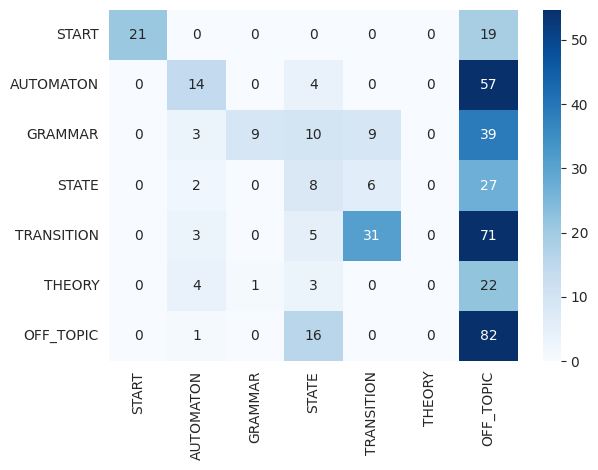

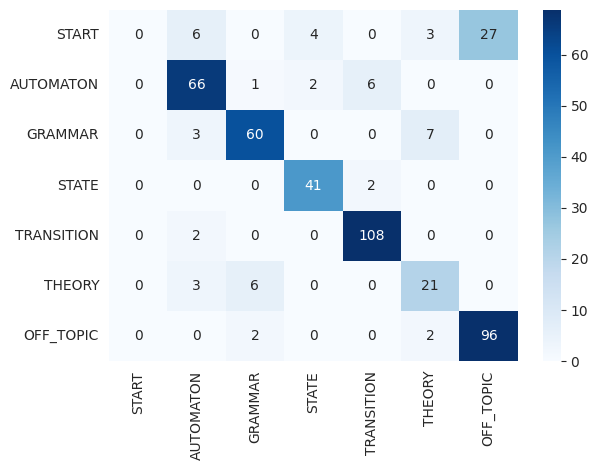

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pictures_base_path_bert = Path(f"./diagrams/{base_model}")
pictures_base_path_bert.mkdir(parents=True, exist_ok=True)
pictures_base_path_aiml = Path(f"./diagrams/aiml")
pictures_base_path_aiml.mkdir(parents=True, exist_ok=True)

# palette = sns.color_palette("viridis", as_cmap=True)
palette = "Blues"

global_subject_labels = merged_df['Global Subject'].unique()

# Main class confusion matrices
conf_matrix = confusion_matrix(merged_df['Global Subject'], merged_df['aiml_main_prediction'],
                               labels=global_subject_labels)

sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap=palette,
            vmax=calculate_vmax(conf_matrix, "std_dev", std_dev_factor=2.5),
            xticklabels=global_subject_labels,
            yticklabels=global_subject_labels)
# plt.title("AIML Main Class - Confusion Matrix")
plt.tight_layout()
plt.savefig(pictures_base_path_aiml / "confusion_matrices_aiml_main.svg", transparent=True)
plt.show()

conf_matrix = confusion_matrix(merged_df['Global Subject'], merged_df['bert_main_prediction'],
                               labels=global_subject_labels)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap=palette,
            vmax=calculate_vmax(conf_matrix, "std_dev", std_dev_factor=2.5),
            xticklabels=global_subject_labels,
            yticklabels=global_subject_labels)
# plt.title("BERT Main Class - Confusion Matrix")
plt.tight_layout()
plt.savefig(pictures_base_path_bert / "confusion_matrices_bert_main.svg")
plt.show()

In [9]:
# Examples where main classes are correct
correct_main_aiml = merged_df.loc[merged_df['Global Subject'] == merged_df['aiml_main_prediction']]
correct_main_bert = merged_df.loc[merged_df['Global Subject'] == merged_df['bert_main_prediction']]

# Sub class accuracy conditioned on correct main class prediction
conditional_accuracy_aiml = (correct_main_aiml['Question Intent'] == correct_main_aiml['aiml_sub_prediction']).mean()
conditional_accuracy_bert = (correct_main_bert['Question Intent'] == correct_main_bert['bert_sub_prediction']).mean()

print(f"AIML Conditional Sub Class Accuracy: {conditional_accuracy_aiml:.2f}")
print(f"BERT Conditional Sub Class Accuracy: {conditional_accuracy_bert:.2f}")

AIML Conditional Sub Class Accuracy: 0.79
BERT Conditional Sub Class Accuracy: 0.59


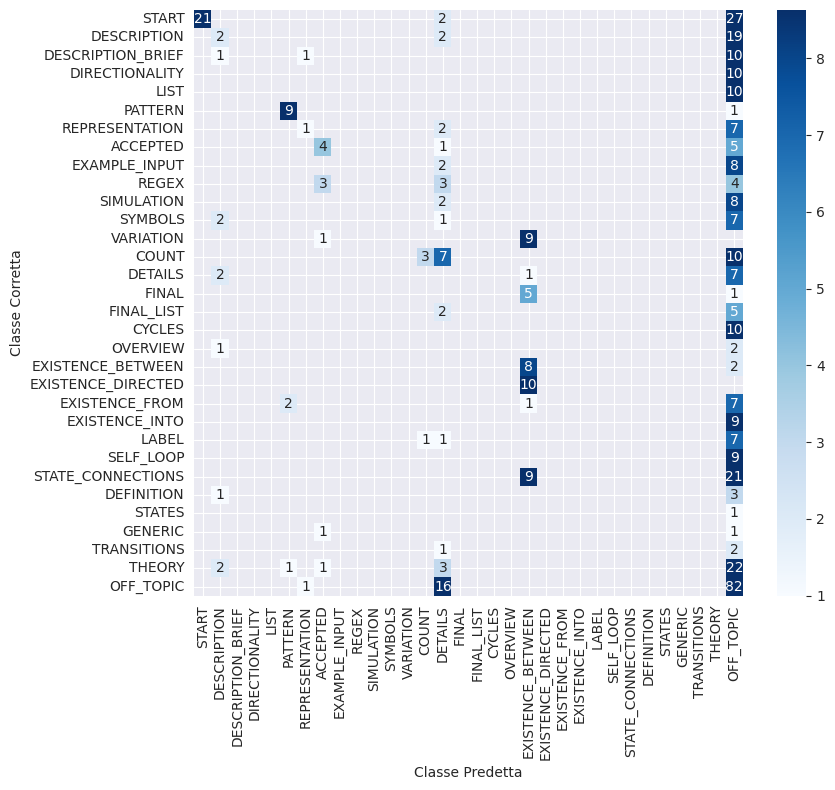

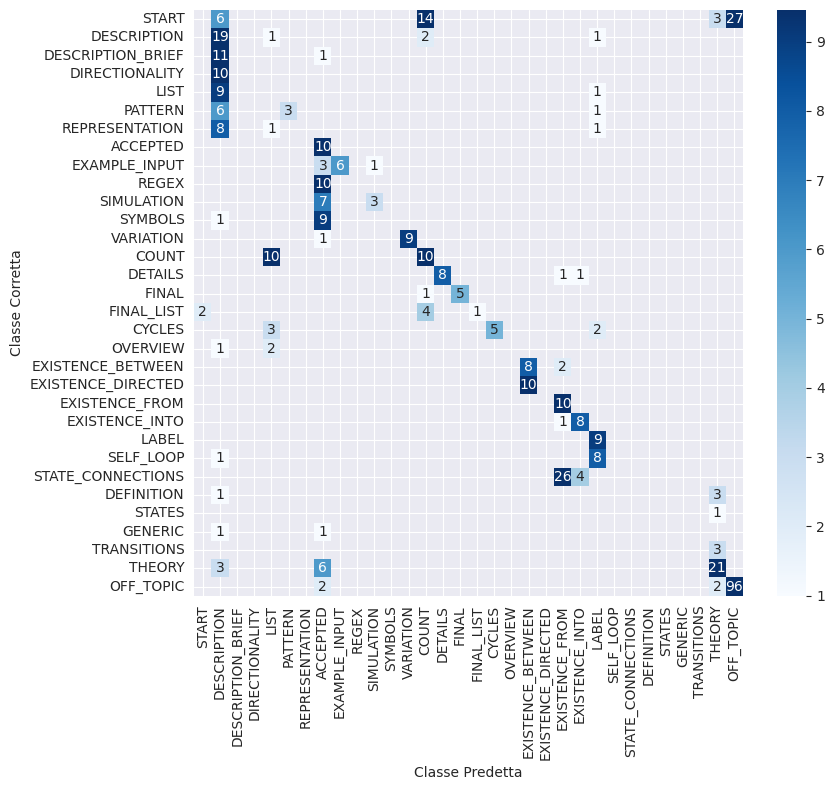

In [10]:
# Subclass confusion matrices for AIML and BERT
sub_class_labels = merged_df['Question Intent'].unique()

# AIML Subclass Confusion Matrix
conf_matrix_aiml_sub = confusion_matrix(merged_df['Question Intent'],
                                        merged_df['aiml_sub_prediction'],
                                        labels=sub_class_labels)

plt.figure(figsize=(9, 8))
sns.heatmap(conf_matrix_aiml_sub,
            annot=True,
            fmt='d',
            cmap=palette,
            mask=conf_matrix_aiml_sub == 0,
            cbar=True,
            vmax=calculate_vmax(conf_matrix_aiml_sub, "std_dev", std_dev_factor=2.5),
            xticklabels=sub_class_labels,
            yticklabels=sub_class_labels)
# plt.title("AIML Sub Prediction - Confusion Matrix")
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Corretta")
plt.tight_layout()
plt.savefig(pictures_base_path_aiml / "confusion_matrices_aiml_sub.svg")
plt.show()

# BERT Subclass Confusion Matrix
conf_matrix_bert_sub = confusion_matrix(merged_df['Question Intent'], merged_df['bert_sub_prediction'],
                                        labels=sub_class_labels)

plt.figure(figsize=(9, 8))
sns.heatmap(conf_matrix_bert_sub,
            annot=True,
            fmt='d',
            cmap=palette,
            mask=conf_matrix_bert_sub == 0,
            cbar=True,
            # vmax=calculate_vmax(conf_matrix_bert_sub),
            # linewidths=0.5,
            # linecolor='black',
            vmax=calculate_vmax(conf_matrix_bert_sub, "std_dev", std_dev_factor=2.5),
            xticklabels=sub_class_labels,
            yticklabels=sub_class_labels)
# plt.title("BERT Sub Prediction - Confusion Matrix")
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Corretta")
plt.tight_layout()
plt.savefig(pictures_base_path_bert / "confusion_matrices_bert_sub.svg")
plt.show()

In [11]:
report_base_path = Path(f"./reports/{base_model}")
report_base_path.mkdir(parents=True, exist_ok=True)

merged_df.to_csv(report_base_path / "merged_predictions.csv", index=False)

with (report_base_path / "classification_reports.txt").open("w") as report_file:
    report_file.write("AIML Main Class Performance:\n")
    report_file.write(
        classification_report(merged_df['Global Subject'], merged_df['aiml_main_prediction'], zero_division=0))
    report_file.write("\n\n")

    report_file.write("BERT Main Class Performance:\n")
    report_file.write(
        classification_report(merged_df['Global Subject'], merged_df['bert_main_prediction'], zero_division=0))
    report_file.write("\n\n")

    report_file.write("AIML Sub Class Performance:\n")
    report_file.write(
        classification_report(merged_df['Question Intent'], merged_df['aiml_sub_prediction'], zero_division=0))
    report_file.write("\n\n")

    report_file.write("BERT Sub Class Performance:\n")
    report_file.write(
        classification_report(merged_df['Question Intent'], merged_df['bert_sub_prediction'], zero_division=0))

    report_file.write("\n\n")

    report_file.write(f"AIML Conditional Sub Class Accuracy: {conditional_accuracy_aiml:.2f}")
    report_file.write("\n\n")

    report_file.write(f"BERT Conditional Sub Class Accuracy: {conditional_accuracy_bert:.2f}")

correct_main_bert.to_csv(report_base_path / "correct_main_bert.csv", index=False)
incorrect_main_bert = merged_df.loc[merged_df['Global Subject'] != merged_df['bert_main_prediction']]
incorrect_main_bert.to_csv(report_base_path / "incorrect_main_bert.csv", index=False)

In [12]:
# aiml_report_base_path = Path(f"./reports/aiml")
# aiml_report_base_path.mkdir(parents=True, exist_ok=True)
#
# correct_main_aiml.to_csv(aiml_report_base_path / "correct_main_aiml.csv", index=False)
# incorrect_main_aiml = merged_df.loc[merged_df['Global Subject'] != merged_df['aiml_main_prediction']]
#
# incorrect_main_aiml.to_csv(aiml_report_base_path / "incorrect_main_aiml.csv", index=False)